# Chapter 10
## Bet Sizing
Your ML algorithm can achieve high accuracy, but if you do not size your bets properly, your investment strategy will inevitably lose money. In this chapter we will review a few approaches to size bets from ML predictions.

In [1]:
# imports
import numpy as np

from scipy.stats import norm, moment

import pandas as pd
import dask.dataframe as dd
from dask import delayed
from dask.diagnostics import ProgressBar
ProgressBar().register()

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

import time
import datetime as dt

from EF3M.ef3m import M2N, rawMoment

from IPython.display import display

----
----
## Exercises
Working our way through the problems. All code can be run independently of outside data, with the optional exception of exercise 4.

#### EXERCISE 10.1
Using the formulation in Section 10.3, plot the bet size ($m$) as a function of the maximum predicted probability ($\tilde{p}$) when $||X|| = 2, 3, ..., 10$.

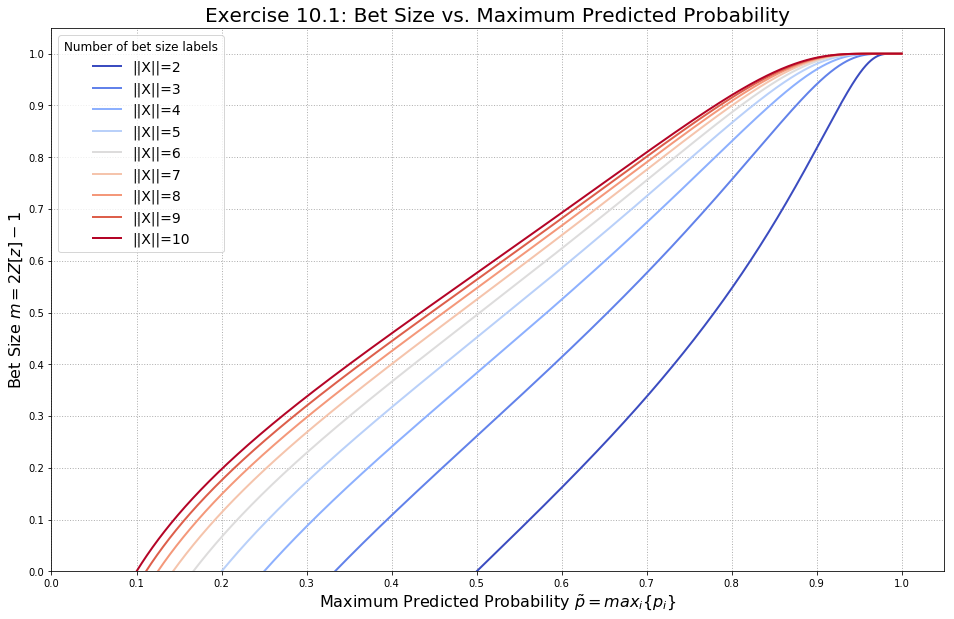

In [2]:
num_classes_list = [i for i in range(2, 11, 1)]  # array of number of classes, 2 to 10
n = 10_000  # number of points to plot
colors = iter(cm.coolwarm(np.linspace(0,1,len(num_classes_list))))

fig_10_1, ax_10_1 = plt.subplots(figsize=(16, 10))

for num_classes in num_classes_list:
    min_prob, max_prob = 1 / num_classes, 1  # possible range for maximum predicted probability, [1/||X||, 1]
    P = np.linspace(min_prob, max_prob, n, endpoint=False)  # range of maximum predicted probabilities to plot
    z = (P - min_prob) / (P*(1-P))**0.5
    m = 2 * norm.cdf(z) - 1
    ax_10_1.plot(P, m, label=f"||X||={num_classes}", linewidth=2, alpha=1, color=colors.__next__())

ax_10_1.set_ylabel("Bet Size $m=2Z[z]-1$", fontsize=16)
ax_10_1.set_xlabel(r"Maximum Predicted Probability $\tilde{p}=max_i${$p_i$}", fontsize=16)
ax_10_1.set_title("Exercise 10.1: Bet Size vs. Maximum Predicted Probability", fontsize=20)
ax_10_1.set_xticks([0.1*i for i in range(11)])
ax_10_1.set_yticks([0.1*i for i in range(11)])
ax_10_1.legend(loc="upper left", fontsize=14, title="Number of bet size labels", title_fontsize=12)
ax_10_1.set_ylim((0,1.05))
ax_10_1.set_xlim((0, 1.05))
ax_10_1.grid(linewidth=1, linestyle=':')

plt.show()

----
#### EXERCISE 10.2
Draw 10,000 random numbers from a uniform distribution with bounds U[.5, 1.]. (Author's note: These exercises are intended to simulate dynamic bet sizing of a long-only strategy.)

__(a)__ Compute bet sizes _m_ for $||X||=2$.

__(b)__ Assign 10,000 consecutive calendar days to the bet sizes.

__(c)__ Draw 10,000 random numbers from a uniform distribution with bounds U[1, 25].

__(d)__ Form a `pandas.Series` indexed by the dates in 2.b, and with values equal to the index shifted forward the number of days in 2.c. This is a `t1` object similar to the ones we used in Chapter 3.

__(e)__ Compute the resulting average active bets, following Section 10.4.
 

In [3]:
# draw random numbers from a uniform distribution (all bets are long)
np.random.seed(0)
sample_size = 10_000
P_t = np.random.uniform(.5, 1., sample_size)  # array of random from uniform dist.


# 2.(a) Compute bet sizes for ||X||=2
z = (P_t - 0.5) /  (P_t*(1-P_t))**0.5
m = 2 * norm.cdf(z) - 1  # bet sizes, x=1


# 2.(b) assign 10,000 consecutive calendar days
start_date = dt.datetime(2000, 1, 1)  # starting at 01-JAN-2000
date_step = dt.timedelta(days=1)
dates = np.array([start_date + i*date_step for i in range(sample_size)])
bet_sizes = pd.Series(data=m, index=dates)


# 2.(c) draw 10,000 random numbers from a uniform distribution
shift_list = np.random.uniform(1., 25., sample_size)
shift_dt = np.array([dt.timedelta(days=d) for d in shift_list])


# 2.(d) create a pandas.Series object
dates_shifted = dates + shift_dt
t1 = pd.Series(data=dates_shifted, index=dates)

# Collect the series into a single DataFrame.
# Add a randomized 'side' indicator so we have both long and short bets.
df_events = pd.concat(objs=[t1, bet_sizes], axis=1)
df_events = df_events.rename(columns={0: 't1', 1: 'bet_size'})
df_events['p'] = P_t
df_events = df_events[['t1', 'p', 'bet_size']]


# 2.(e) compute the average active bets
avg_bet = pd.Series()
active_bets = pd.Series()
for idx, val in t1.iteritems():
    active_idx = t1[(t1.index<=idx)&(t1>idx)].index
    num_active = len(active_idx)
    active_bets[idx] = num_active
    avg_bet[idx] = bet_sizes[active_idx].mean()

df_events['num_active_bets'] = active_bets
df_events['avg_active_bets'] = avg_bet


#plt.plot(bet_sizes.index, bet_sizes.values, avg_bet.index, avg_bet.values, alpha=0.6)
display(df_events.head(10))

t1         p  bet_size  num_active_bets  \
2000-01-01 2000-01-19 23:00:08.486002  0.774407  0.488510                1   
2000-01-02 2000-01-07 07:47:48.333891  0.857595  0.693816                2   
2000-01-03 2000-01-13 08:04:38.392503  0.801382  0.550002                3   
2000-01-04 2000-01-05 21:39:27.736493  0.772442  0.484193                4   
2000-01-05 2000-01-06 06:47:23.055965  0.711827  0.360002                5   
2000-01-06 2000-01-30 21:51:01.058622  0.822947  0.602473                5   
2000-01-07 2000-01-19 17:12:04.590144  0.718794  0.373496                5   
2000-01-08 2000-01-17 22:17:10.550572  0.945887  0.951258                5   
2000-01-09 2000-01-14 16:59:42.455288  0.981831  0.999691                6   
2000-01-10 2000-01-30 08:56:33.839416  0.691721  0.321986                7   

            avg_active_bets  
2000-01-01         0.488510  
2000-01-02         0.591163  
2000-01-03         0.577443  
2000-01-04         0.554130  
2000-01-05         0.515304  
2000-01-06         0.538960  
2000-01-07         0.541659  
2000-01-08         0.593148  
2000-01-09         0.660905  
2000-01-10         0.612488

----
#### EXERCISE 10.3
Using the `t1` object from exercise 2.d:

__(a)__ Determine the maximum number of concurrent long bets, $\bar{c_l}$.

__(b)__ Determine the maximum number of concurrent short bets, $\bar{c_s}$.

__(c)__ Derive the bet size as $m_t = c_{t,l}\frac{1}{\bar{c_l}} - c_{t,s}\frac{1}{\bar{c_s}}$, where $c_{t,l}$ is the number of concurrent long bets at time $t$, and $c_{t,s}$ is the number of concurrent short bets at time $t$.

In [4]:
# 3.(a) max number of concurrent long bets
df_events2 = df_events.copy()
active_long = pd.Series()

for idx in df_events2.index:
    df_long_active_idx = set(df_events2[(df_events2.index<=idx)&(df_events2.t1>idx)].index)
    active_long[idx] = len(df_long_active_idx)


print(f"  3.(a) Maximum number of concurrent long bets: {active_long.max()}")

# 3.(b) max number of concurrent short bets
# p[x=1]: U[0.5, 1], thus all bets are long, and the 
# number of concurrent short bets is always zero.
print(f"  3.(b) Maximum number of concurrent short bets: {0}")


# 3.(c) bet size as difference between fractions of concurrent long and short bets
bet_sizes_2 = active_long/active_long.max() - 0  # number of shorts bets is always 0

df_events2 = df_events2.assign(active_long=active_long,
                               bet_sizes2=bet_sizes_2)
display(df_events2.head(10))

  3.(a) Maximum number of concurrent long bets: 20
  3.(b) Maximum number of concurrent short bets: 0


t1         p  bet_size  num_active_bets  \
2000-01-01 2000-01-19 23:00:08.486002  0.774407  0.488510                1   
2000-01-02 2000-01-07 07:47:48.333891  0.857595  0.693816                2   
2000-01-03 2000-01-13 08:04:38.392503  0.801382  0.550002                3   
2000-01-04 2000-01-05 21:39:27.736493  0.772442  0.484193                4   
2000-01-05 2000-01-06 06:47:23.055965  0.711827  0.360002                5   
2000-01-06 2000-01-30 21:51:01.058622  0.822947  0.602473                5   
2000-01-07 2000-01-19 17:12:04.590144  0.718794  0.373496                5   
2000-01-08 2000-01-17 22:17:10.550572  0.945887  0.951258                5   
2000-01-09 2000-01-14 16:59:42.455288  0.981831  0.999691                6   
2000-01-10 2000-01-30 08:56:33.839416  0.691721  0.321986                7   

            avg_active_bets  active_long  bet_sizes2  
2000-01-01         0.488510            1        0.05  
2000-01-02         0.591163            2        0.10  
2000-01-03         0.577443            3        0.15  
2000-01-04         0.554130            4        0.20  
2000-01-05         0.515304            5        0.25  
2000-01-06         0.538960            5        0.25  
2000-01-07         0.541659            5        0.25  
2000-01-08         0.593148            5        0.25  
2000-01-09         0.660905            6        0.30  
2000-01-10         0.612488            7        0.35

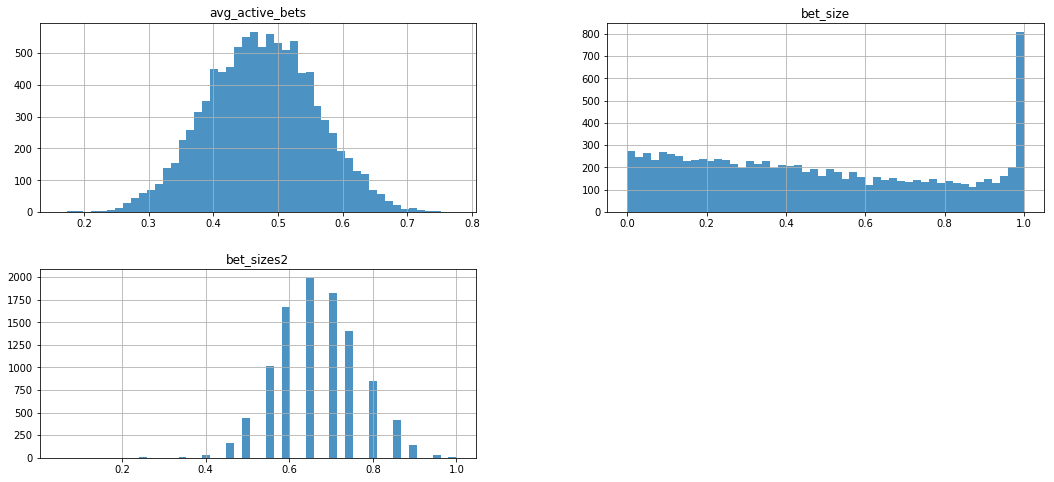

In [5]:
ax_10_3 = df_events2.hist(['bet_size', 'avg_active_bets', 'bet_sizes2'], figsize=(18, 8), alpha=0.8, bins=50)

----
#### EXERCISE 10.4
Using the `t1` object from exercise 2.d:

__(a)__ Compute the series $c_t = c_{t,l} - c_{t,s}$, where $c_{t,l}$ is the number of concurrent long bets at time $t$, and $c_{t,s}$ is the number of concurrent short bets at time $t$.

__(b)__ Fit a mixture of two Gaussians on {$c_t$}. You may want to use the method described in LÃ³pez de Prado and Foreman (2014).

__(c)__ Derive the bet size as $$m_t = \begin{cases} \frac{F[c_t]-F[0]}{1-F[0]}, & \text{if } c_t\geq 0\\\
                                                     \frac{F[c_t]-F[0]}{F[0]}, & \text{if } c_t\le 0
\end{cases}$$
where $F[x]$ is the CDF of the fitted mixture of two Gaussians for a value of $x$.

__(d)__ Explain how this series ${m_t}$ differ from the bet size computed in exercise 3.


Mean (first raw moment): 13.375
First 5 centered moments
E[r^1] = 0.0
E[r^2] = 3.948975
E[r^3] = -0.33733125
E[r^4] = 51.253873828125
E[r^5] = -78.8945244140625


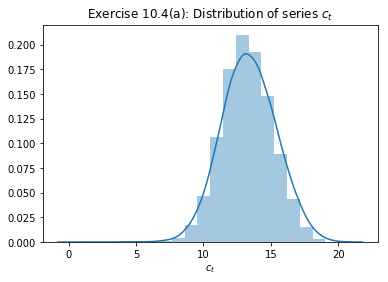

In [6]:
# 4.(a) compute the series c_t = c_{t,l} (all bets are long)
# ======================================================
df_events2['c_t'] = df_events2.active_long - 0  # number of short bets is always zero
ax_10_4a = sns.distplot(df_events2['c_t'], bins=20, kde=True, kde_kws={"bw":0.6})
ax_10_4a.set_xlabel('$c_t$')
ax_10_4a.set_title("Exercise 10.4(a): Distribution of series $c_t$")

# 4.(b) fit a mixture of 2 Gaussians
# compute the first 5 centered moments
# ======================================================
print(f"Mean (first raw moment): {df_events2.c_t.mean()}")
print("First 5 centered moments")
mmnts = [moment(df_events2.c_t.to_numpy(), moment=i) for i in range(1, 6)]
for i, mnt in enumerate(mmnts):
    print(f"E[r^{i+1}] = {mnt}")

In [7]:
# The EF3M algorithm uses the first 5 raw moments, thus
# we need to calculate these from the 5 centered moments
# calculated above.
# ======================================================
raw_mmnts = rawMoment(central_moments=mmnts, dist_mean=df_events2.c_t.mean())
for i, mnt in enumerate(raw_mmnts):
    print(f"E_Raw[r^{i+1}]={mnt}")

E_Raw[r^1]=13.375
E_Raw[r^2]=182.8396
E_Raw[r^3]=2550.7774
E_Raw[r^4]=36273.67
E_Raw[r^5]=525255.703


=== Values chosen based on the mode of the distribution of results from EF3M (1000 runs) ===
Mode of KDE (mu1): 12.558
Mode of KDE (mu2): 13.389
Mode of KDE (sigma1): 3.35
Mode of KDE (sigma2): 1.953
Mode of KDE (p1): 0.014


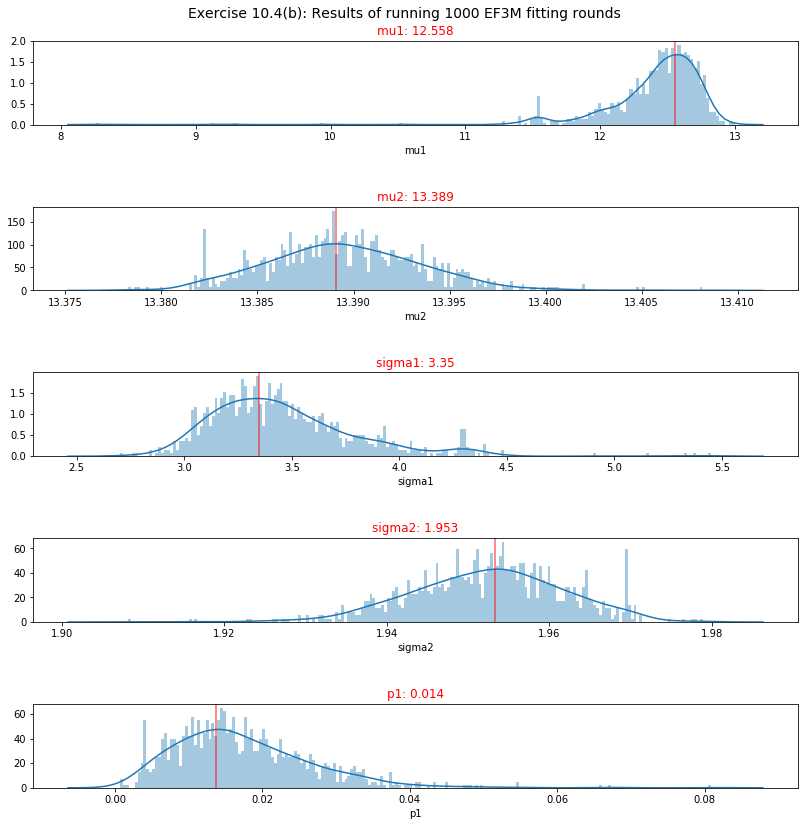

In [8]:
# Now that we have the first 5 raw moments, we can apply the
# EF3M algorithm. We use variant #2 since we have the 5th
# moment, and it converges faster in practice.
# While the first 3 moments are fit exactly, there is not
# a unqiue solution to this, so we have to make multple runs
# to find the most likely value.
# ======================================================
# uncomment to run the fit, takes about 9 hours for 1000 runs using these parameters
n_runs = 1000
#m2n = EF3M.ef3m.M2N(raw_mmnts)
#df_10_4 = m2n.mpFit(raw_mmnts, epsilon=10**-5, factor=5, n_runs=1000, variant=2, maxIter=10_000_000)
#df_10_4.to_pickle(f"DF_M2N_fit_10d4_{n_runs}runs_type2.pkl")
#print(df_10_4.head(10))

# saved data of 1000 runs, imported to save time
df_10_4 = pd.read_pickle("DF_M2N_fit_10d4_1000runs_type2.pkl")


# Here we visualize the results of the 1000 runs, and
# find the most likely value for each parameter from the 
# kernel density estimate of the distribution.
# ======================================================
fig_10_4b, ax_10_4b = plt.subplots(nrows=5, ncols=1, figsize=(12,12))
cols = ['mu1', 'mu2', 'sigma1', 'sigma2', 'p1']
bins = 250
fit_parameters = []

print(f"=== Values chosen based on the mode of the distribution of results from EF3M ({n_runs} runs) ===")

for col_i, ax in enumerate(ax_10_4b.flatten()):
    col = cols[col_i]
    df = df_10_4.copy()
    df[col+'_bin'] = pd.cut(df[col], bins=bins)
    df = df.groupby([col+'_bin']).count()
    ax = sns.distplot(df_10_4[col], bins=200, kde=True, ax=ax)
    #ax = df_10_4[col].plot.kde()
    dd = ax.get_lines()[0].get_data()
    most_probable_val = dd[0][np.argmax(dd[1])]
    fit_parameters.append(most_probable_val)
    ax.axvline(most_probable_val, color='red', alpha=0.6)
    ax.set_title(f"{col}: {round(most_probable_val,3)}", color='red')
    print(f"Mode of KDE ({col}):", round(dd[0][np.argmax(dd[1])], 3))
fig_10_4b.suptitle(f"Exercise 10.4(b): Results of running {n_runs} EF3M fitting rounds", fontsize=14)
fig_10_4b.tight_layout(pad=3.5)
plt.show()

The CDF of a [mixture of $n$ distributions](https://en.wikipedia.org/wiki/Mixture_distribution), $F_{mixture}(x)$, can be represented as the weighted sum of the individual distributions:
$$ F_{mixture}(x) = \sum_{i=1}^{n}{w_i F_{i, norm}(x)}$$
Where $w_i$ are the weights corresponding to each of the individual cumulative distribution functions of a normal distribution, $F_{i,norm}(x)$.

Thus, for the mixture of $n=2$ distributions in this question, the CDF of the mixture, $F(x)$, is:
$$ F(x) = p_1 F_{norm}(x, \mu_1, \sigma_1) + (1-p_1) F_{norm}(x, \mu_2, \sigma_2) $$
Where $F_{norm}(x, \mu_i, \sigma_i)$ is the cumulative distribution evaluated at $x$ of a Normal distribution with parameters $\mu_i$ and $\sigma_i$, and $p_1$ is the probability of a given random sample being drawn from the first distribution.

c_t    bet_sizes2    bet_sizes3
count  10000.000000  10000.000000  10000.000000
mean      13.375000      0.668750      0.498029
std        1.987302      0.099365      0.290336
min        1.000000      0.050000      0.000003
25%       12.000000      0.600000      0.241160
50%       13.000000      0.650000      0.422847
75%       15.000000      0.750000      0.794848
max       20.000000      1.000000      0.999469

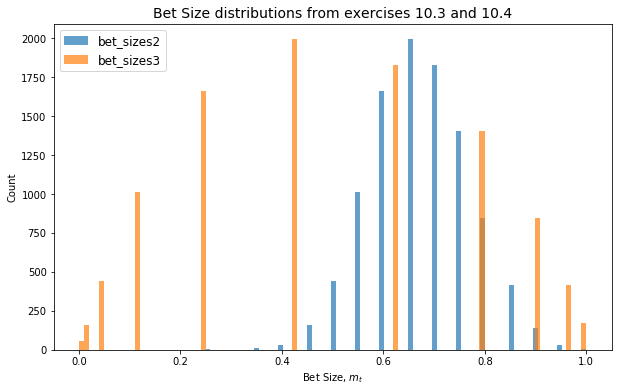

In [9]:
# 4.(c) Calculating the bet size using the mixture of 2 Gaussians
# ======================================================

def cdf_mixture(x, parameters):
    # the CDF of a mixture of 2 normal distributions, evaluated at x
    # :param x: (float) x-value
    # :param parameters: (list) mixture parameters, [mu1, mu2, sigma1, sigma2, p1]
    # :return: (float) CDF of the mixture
    # ===================================
    mu1, mu2, sigma1, sigma2, p1 = parameters  # for clarity
    return p1*norm.cdf(x, mu1, sigma1) + (1-p1)*norm.cdf(x, mu2, sigma2)

def bet_size_mixed(c_t, parameters):
    # return the bet size based on the description provided in
    # question 10.4(c).
    # :param c_t: (int) different of the number of concurrent long bets minus short bets
    # :param parameters: (list) mixture parameters, [mu1, mu2, sigma1, sigma2, p1]
    # :return: (float) bet size
    # =========================
    if c_t >= 0:
        return ( cdf_mixture(c_t, parameters) - cdf_mixture(0, parameters) ) / ( 1 - cdf_mixture(0, parameters) )
    else:
        ( cdf_mixture(c_t, parameters) - cdf_mixture(0, parameters) ) / cdf_mixture(0, parameters)

df_events2['bet_sizes3'] = df_events2.c_t.apply(lambda c: bet_size_mixed(c, fit_parameters))
fig_10_4c, ax_10_4c = plt.subplots(figsize=(10,6))
for c in ['bet_sizes2', 'bet_sizes3']:
    ax_10_4c.hist(df_events2[c].to_numpy(), bins=100, label=c, alpha=0.7)
ax_10_4c.legend(loc='upper left', fontsize=12)
ax_10_4c.set_xlabel("Bet Size, $m_t$")
ax_10_4c.set_ylabel("Count")
ax_10_4c.set_title("Bet Size distributions from exercises 10.3 and 10.4", fontsize=14)
display(df_events2[['c_t', 'bet_sizes2', 'bet_sizes3']].describe())

**4.(d) Discussion**

The bet size distribution calculated in exercise 3, `bet_sizes2`, and exercise 4, `bet_sizes3`, are both made up of discrete values. Since the series $\{c_t\}$ is made up of integers between 1 and 20, the bet size from exercise 3, $m_t=c_{t,l}\frac{1}{\tilde{c_l}}$, is also a set of discrete values bounded by $[\frac{1}{\tilde{c_l}}, 1]$ (since there is always at least 1 active bet for any given $t$). However, $98\%$ of all bet sizes fall between $[0.45, 0.9]$, with a mean at $0.67$.

In exercise 4 the bet size is calculated using $c_t$ as an input, which results in the bet sizes being a series composed of 20 unique values. Here the bet size values are bounded by $(0, 1)$ but are spread out more evenly across the range than in exercise 3; here $98\%$ of the bet sizes fall between $[0.014, 0.998]$, with a lower mean of $0.50$.

Even though we are examining a *long-only* betting strategy, the bet sizes calculated in exercise 4 typically get much closer to zero (i.e. not placing the bet at all), whereas in exercise 3 $99\%$ of all bet sizes are at least $0.45$.

In [10]:
display(df_events2.quantile([0.001, 0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 0.999]))

p  bet_size  num_active_bets  avg_active_bets  active_long  \
0.001  0.500363  0.000580              7.0         0.229428          7.0   
0.010  0.504100  0.006542              9.0         0.284154          9.0   
0.050  0.523658  0.037781             10.0         0.338003         10.0   
0.250  0.622655  0.199764             12.0         0.415641         12.0   
0.500  0.746751  0.429563             13.0         0.474385         13.0   
0.750  0.874146  0.740689             15.0         0.532511         15.0   
0.950  0.974606  0.997446             17.0         0.613095         17.0   
0.990  0.994703  1.000000             18.0         0.663246         18.0   
0.999  0.999551  1.000000             19.0         0.714011         19.0   

       bet_sizes2   c_t  bet_sizes3  
0.001        0.35   7.0    0.001190  
0.010        0.45   9.0    0.014117  
0.050        0.50  10.0    0.043836  
0.250        0.60  12.0    0.241160  
0.500        0.65  13.0    0.422847  
0.750        0.75  15.0    0.794848  
0.950        0.85  17.0    0.966923  
0.990        0.90  18.0    0.990290  
0.999        0.95  19.0    0.997620

----
#### EXERCISE 10.5
Repeat exercise 1, where you discretize $m$ with a `stepSize=.01`, `setpSize=.05`, and `stepSize=.1`.

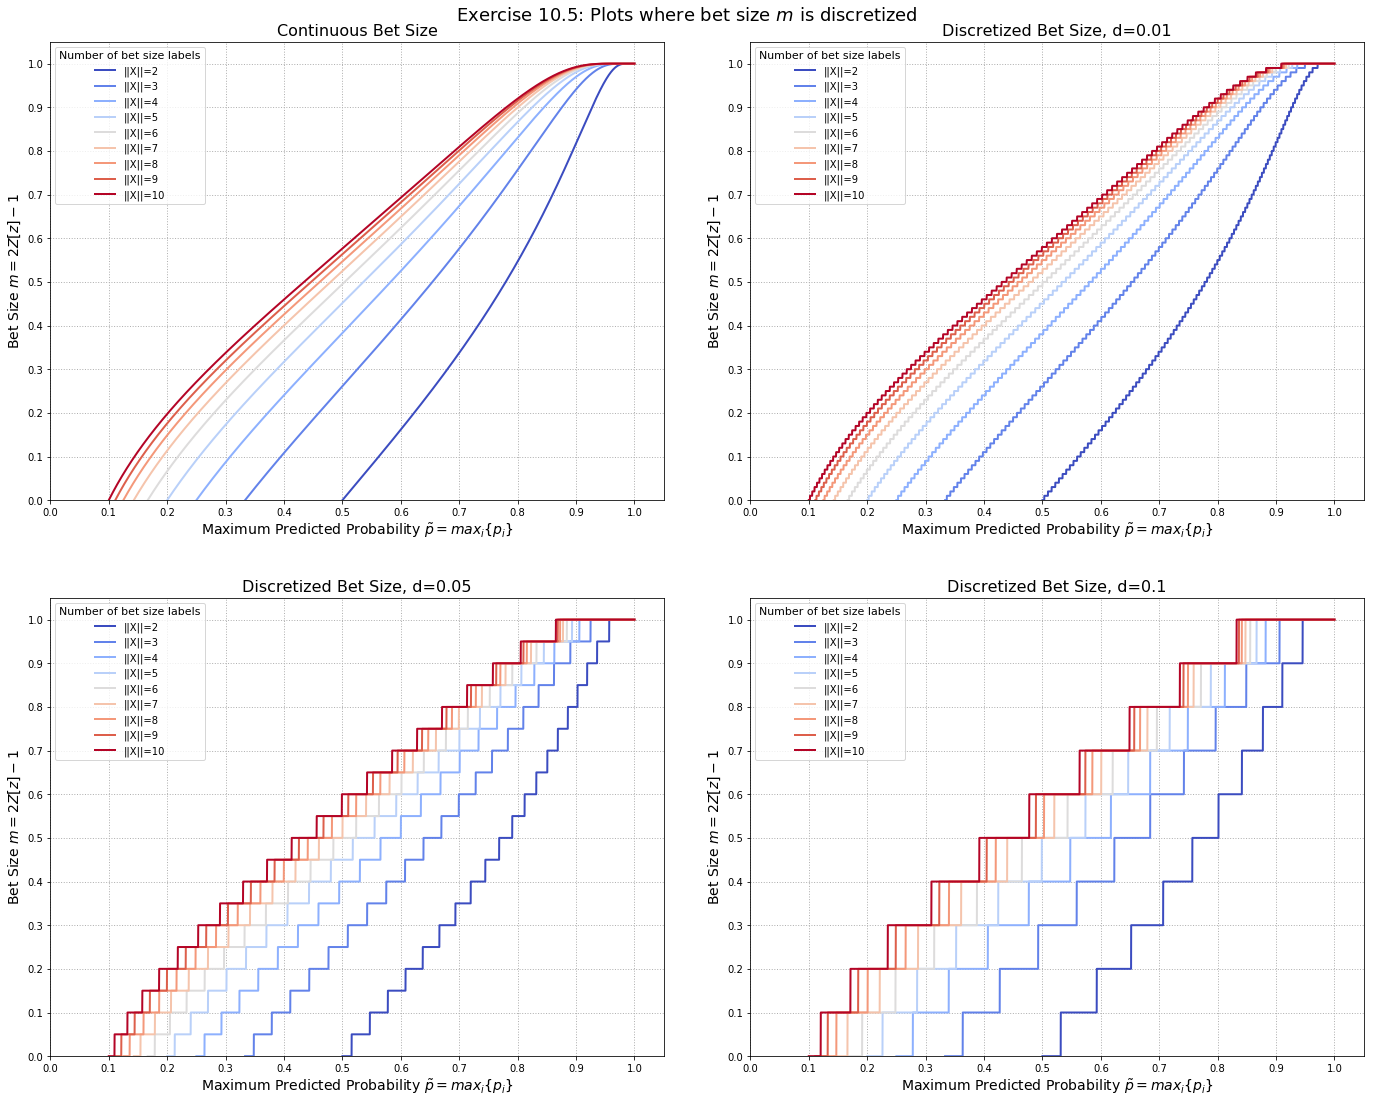

In [11]:
num_classes_list = [i for i in range(2, 11, 1)]  # array of number of classes, 2 to 10
n = 10000  # number of points to plot


fig_10_5, ax_10_5 = plt.subplots(2, 2, figsize=(20, 16))
ax_10_5 = fig_10_5.get_axes()
d_list = [None, 0.01, 0.05, 0.1]
d = d_list[2]

for i, axi in enumerate(ax_10_5):
    colors = iter(cm.coolwarm(np.linspace(0,1,len(num_classes_list))))
    for num_classes in num_classes_list:
        d = d_list[i]
        min_prob, max_prob = 1 / num_classes, 1  # possible range for maximum predicted probability, [1/||X||, 1]
        P = np.linspace(min_prob, max_prob, n, endpoint=False)  # range of maximum predicted probabilities to plot
        z = (P - min_prob) / (P*(1-P))**0.5
        m = 2 * norm.cdf(z) - 1
        if not isinstance(d, type(None)):
            m = (m/d).round()*d
        axi.plot(P, m, label=f"||X||={num_classes}", linewidth=2, alpha=1, color=colors.__next__())

    axi.set_ylabel("Bet Size $m=2Z[z]-1$", fontsize=14)
    axi.set_xlabel(r"Maximum Predicted Probability $\tilde{p}=max_i${$p_i$}", fontsize=14)
    axi.set_xticks([0.1*i for i in range(11)])
    axi.set_yticks([0.1*i for i in range(11)])
    axi.legend(loc="upper left", fontsize=10, title="Number of bet size labels", title_fontsize=11)
    axi.set_ylim((0,1.05))
    axi.set_xlim((0, 1.05))
    if not isinstance(d, type(None)):
        axi.set_title(f"Discretized Bet Size, d={d}", fontsize=16)
    else:
        axi.set_title(f"Continuous Bet Size", fontsize=16)
    axi.grid(linewidth=1, linestyle=':')

fig_10_5.suptitle("Exercise 10.5: Plots where bet size $m$ is discretized", fontsize=18)
fig_10_5.tight_layout(pad=4)
plt.show()

----
#### EXERCISE 10.6
Rewrite the equations in Section 10.6, so that the bet size is determined by a power function rather than a sigmoid function.

We can substitute a power function to calculate bet size, $\tilde{m}$:

$$\tilde{m}[\omega, x] = sgn[x]|x|^\omega$$

$L[f_i, \omega, \tilde{m}]$, the inverse function of $\tilde{m}[\omega, x]$ with respect to the market price $p_t$, can be rewritten as:

$$L[f_i, \omega, \tilde{m}] = f_i - sgn[\tilde{m}]|\tilde{m}|^{1/\omega}$$

The inverse of $\tilde{m}[\omega, x]$ with respect to $\omega$ can be rewritten as:

$$\omega = \frac{log[|\tilde{m}|]}{log[|x|]}$$

Where $x = f_i - p_t$ is still the divergence between the current market price, $p_t$, and the price forecast, $f_i$.

----
#### EXERCISE 10.7
Modify Snippet 10.4 so that in implements the equations you derived in exercise 6.

In [12]:
# Snippet 10.4, modified to use a power function for the Bet Size
# ===============================================================
# pos    : current position
# tPos   : target position
# w      : coefficient for regulating width of the bet size function (sigmoid, power)
# f      : forecast price
# mP     : market price
# x      : divergence, f - mP
# maxPos : maximum absolute position size
# ===============================================================

def betSize_power(w, x):
    sgn = np.sign(x)
    return sgn * abs(x)**w

def getTPos_power(w, f, mP, maxPos):
    return int( betSize_power(w, f-mP)*maxPos )

def invPrice_power(f, w, m):
    sgn = np.sign(m)
    return f - sgn*abs(m)**(1/w)

def limitPrice_power(tPos, pos, f, w, maxPos):
    sgn = np.sign(tPos-pos)
    lP = 0
    for j in range(abs(pos+sgn), abs(tPos+1)):
        lP += invPrice_power(f, w, j/float(maxPos))
    lP = lP / (tPos-pos)
    return lP

def getW_power(x, m):
    return np.log(abs(m)) / np.log(abs(x))


In [13]:
mP, f, wParams = 100, 115, {'divergence': 10, 'm': 0.95}
w = getW_power(wParams['divergence'], wParams['m'])  # calibrate w

# checking forward and backward calculations
m_test = betSize_power(w, f-mP)
mP_test = invPrice_power(f, w, m_test)
w_test = getW_power(f-mP, m_test)
print(f"Market price: {mP}; Result of inverse price: {mP_test}; Diff: {abs(mP-mP_test)}")
print(f"w: {w}; Result of inverse w: {w_test}; Diff: {abs(w-w_test)}")


Market price: 100; Result of inverse price: 100.00000000000003; Diff: 2.842170943040401e-14
w: -0.02227639471115225; Result of inverse w: -0.022276394711152232; Diff: 1.734723475976807e-17


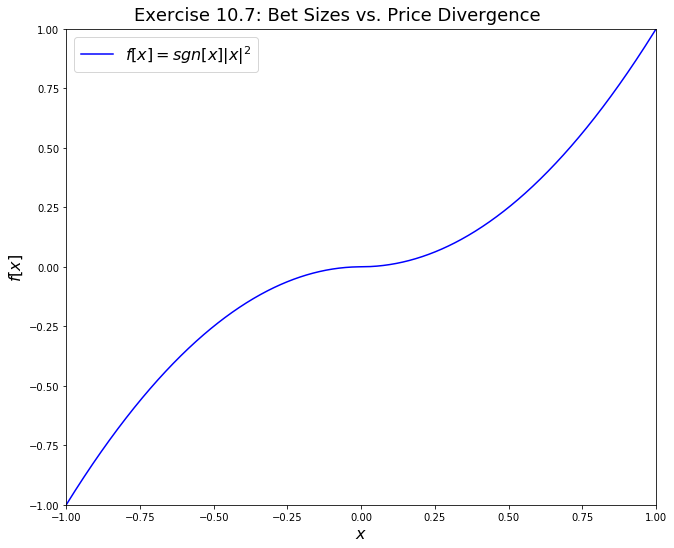

In [14]:
# setup data for replicating Figure 10.3
mP, f, wParams = 100, 115, {'divergence': 10, 'm': 0.95}
n_points = 1000
X = np.linspace(-1.0, 1.0, n_points)

w = 2
bet_sizes_power = np.array([betSize_power(w, xi) for xi in X])

# plotting
fig_10_7, ax_10_7 = plt.subplots(figsize=(10,8))
ax_10_7.plot(X, bet_sizes_power, label='$f[x]=sgn[x]|x|^2$', color='blue', linestyle='-')
ax_10_7.set_xlabel("$x$", fontsize=16)
ax_10_7.set_ylabel("$f[x]$", fontsize=16)
ax_10_7.set_xlim((-1, 1))
ax_10_7.set_ylim((-1, 1))
fig_10_7.suptitle("Exercise 10.7: Bet Sizes vs. Price Divergence", fontsize=18)
plt.legend(loc='upper left', fontsize=16)
fig_10_7.tight_layout(pad=3)
plt.show()